In [173]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

from sklearn import preprocessing, neighbors, grid_search, tree, ensemble, metrics, cross_validation, externals

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.notebook_repr_html', True)

%matplotlib inline
plt.style.use('ggplot')
from sklearn import linear_model

In [143]:
df = pd.read_csv(os.path.join('..', 'Dataset', 'QueryRes.csv'))

df.head()

,user_id,sum,sec,sessions_completed,gender,experience_level,estimate_birth_day,focus,start_date
0,16,225000,225,1380,m,"{""mindfulness"":""low""}",1982-03-14 04:32:24.435+00,mindfulness,2015-04-09 20:50:12.418+00
1,41,1795000,1795,19562,f,"{""yoga"":""medium""}",1969-04-21 13:25:48.392+00,yoga,NaN
2,104,3750000,3750,45846,f,"{""mindfulness"":""high""}",1958-04-24 20:23:59.469+00,mindfulness,NaN
3,131,635000,635,1438,f,"{""mindfulness"":""medium""}",1968-04-27 23:50:42.827+00,mindfulness,NaN
4,155,810000,810,43444,f,"{""mindfulness"":""high""}",1963-04-25 20:15:37.788+00,mindfulness,NaN


In [144]:
def my_first_classifier(row):
    if row.experience_level == '{"mindfulness":"none"}':
        return 0
    elif row.experience_level == '{"yoga":"none"}':
        return 0
    elif row.experience_level == '{"mindfulness":"low"}':
        return 1
    elif row.experience_level == '{"yoga":"low"}':
        return 1
    elif row.experience_level == '{"mindfulness":"medium"}':
        return 2
    elif row.experience_level == '{"yoga":"medium"}':
        return 2
    elif row.experience_level == '{"mindfulness":"high"}':
        return 3
    elif row.experience_level == '{"yoga":"high"}':
        return 3
    else:
        return row.experience_level
   
experience = df.apply(my_first_classifier, axis = 1)

cat=experience.rename("experience")

df=df.join(cat)
    

In [145]:
df.head()

,user_id,sum,sec,sessions_completed,gender,experience_level,estimate_birth_day,focus,start_date,experience
0,16,225000,225,1380,m,"{""mindfulness"":""low""}",1982-03-14 04:32:24.435+00,mindfulness,2015-04-09 20:50:12.418+00,1
1,41,1795000,1795,19562,f,"{""yoga"":""medium""}",1969-04-21 13:25:48.392+00,yoga,NaN,2
2,104,3750000,3750,45846,f,"{""mindfulness"":""high""}",1958-04-24 20:23:59.469+00,mindfulness,NaN,3
3,131,635000,635,1438,f,"{""mindfulness"":""medium""}",1968-04-27 23:50:42.827+00,mindfulness,NaN,2
4,155,810000,810,43444,f,"{""mindfulness"":""high""}",1963-04-25 20:15:37.788+00,mindfulness,NaN,3


In [146]:
df.experience.unique()

array([1, 2, 3, 0])

In [147]:
def start_date(row):
    if row.start_date > 0:
        return 1
    else:
        return 0
    
paid = df.apply(start_date, axis = 1)

cat=paid.rename("paid")

df=df.join(cat)

In [148]:
df.paid.unique()

array([1, 0])

In [149]:
df.drop(['experience_level','start_date'], axis = 1, inplace = True)

In [150]:
df.head()

,user_id,sum,sec,sessions_completed,gender,estimate_birth_day,focus,experience,paid
0,16,225000,225,1380,m,1982-03-14 04:32:24.435+00,mindfulness,1,1
1,41,1795000,1795,19562,f,1969-04-21 13:25:48.392+00,yoga,2,0
2,104,3750000,3750,45846,f,1958-04-24 20:23:59.469+00,mindfulness,3,0
3,131,635000,635,1438,f,1968-04-27 23:50:42.827+00,mindfulness,2,0
4,155,810000,810,43444,f,1963-04-25 20:15:37.788+00,mindfulness,3,0


In [151]:
def focus_n(row):
    if row.focus == 'yoga':
        return 1
    else:
        return 0
    
focus_n = df.apply(focus_n, axis = 1)

cat=focus_n.rename("focus_n")

df=df.join(cat)

In [152]:
df.head()

,user_id,sum,sec,sessions_completed,gender,estimate_birth_day,focus,experience,paid,focus_n
0,16,225000,225,1380,m,1982-03-14 04:32:24.435+00,mindfulness,1,1,0
1,41,1795000,1795,19562,f,1969-04-21 13:25:48.392+00,yoga,2,0,1
2,104,3750000,3750,45846,f,1958-04-24 20:23:59.469+00,mindfulness,3,0,0
3,131,635000,635,1438,f,1968-04-27 23:50:42.827+00,mindfulness,2,0,0
4,155,810000,810,43444,f,1963-04-25 20:15:37.788+00,mindfulness,3,0,0


In [153]:
df.drop(['focus'], axis = 1, inplace = True)

In [186]:
df.corr()

,user_id,sum,sec,sessions_completed,paid,focus_n,exp_0,exp_1,exp_2,exp_3
user_id,1.000000,0.003562,0.003562,0.006119,-0.020385,0.062890,-0.004965,-0.002812,0.016148,-0.018247
sum,0.003562,1.000000,1.000000,0.572262,0.240010,0.017417,-0.065667,-0.013468,0.057344,0.041439
sec,0.003562,1.000000,1.000000,0.572262,0.240010,0.017417,-0.065667,-0.013468,0.057344,0.041439
sessions_completed,0.006119,0.572262,0.572262,1.000000,0.330722,-0.004203,-0.031549,-0.011590,0.035359,0.013612
paid,-0.020385,0.240010,0.240010,0.330722,1.000000,0.006682,-0.047245,0.005370,0.031540,0.020330
focus_n,0.062890,0.017417,0.017417,-0.004203,0.006682,1.000000,-0.025954,-0.160896,0.110093,0.141713
exp_0,-0.004965,-0.065667,-0.065667,-0.031549,-0.047245,-0.025954,1.000000,-0.426703,-0.498906,-0.162824
exp_1,-0.002812,-0.013468,-0.013468,-0.011590,0.005370,-0.160896,-0.426703,1.000000,-0.455416,-0.148631
exp_2,0.016148,0.057344,0.057344,0.035359,0.031540,0.110093,-0.498906,-0.455416,1.000000,-0.173781
exp_3,-0.018247,0.041439,0.041439,0.013612,0.020330,0.141713,-0.162824,-0.148631,-0.173781,1.000000


In [155]:
df.paid.sum()

342

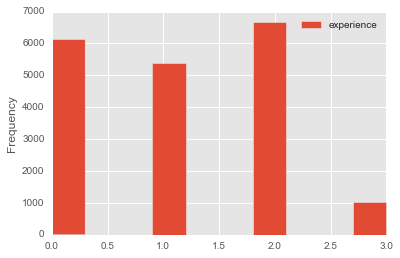

In [156]:
df.plot(x = 'paid', y = 'experience', kind = 'hist')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12260fb50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1245648d0>]], dtype=object)

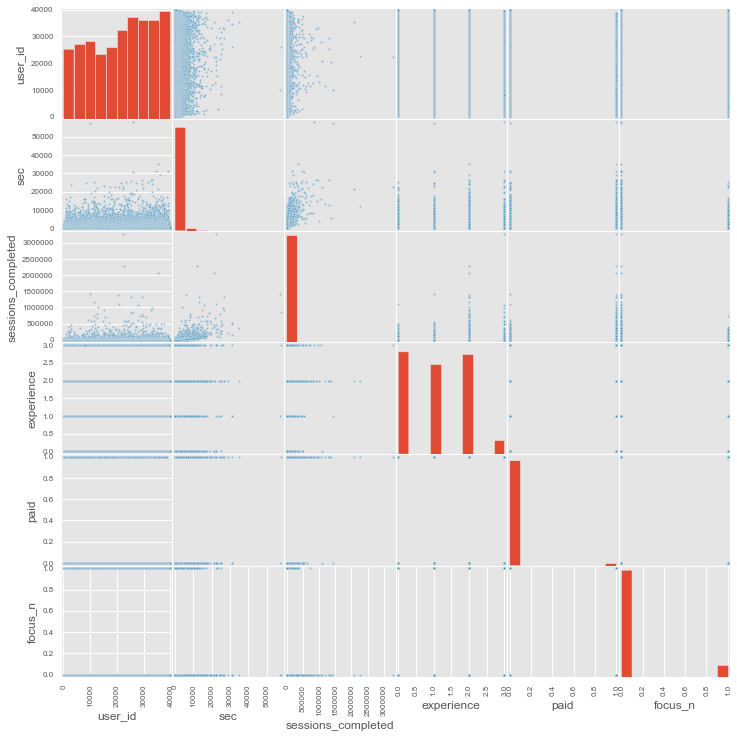

In [89]:
pd.tools.plotting.scatter_matrix(df, figsize=(12, 12))

In [157]:
df.head()

,user_id,sum,sec,sessions_completed,gender,estimate_birth_day,experience,paid,focus_n
0,16,225000,225,1380,m,1982-03-14 04:32:24.435+00,1,1,0
1,41,1795000,1795,19562,f,1969-04-21 13:25:48.392+00,2,0,1
2,104,3750000,3750,45846,f,1958-04-24 20:23:59.469+00,3,0,0
3,131,635000,635,1438,f,1968-04-27 23:50:42.827+00,2,0,0
4,155,810000,810,43444,f,1963-04-25 20:15:37.788+00,3,0,0


In [158]:
exp_df = pd.get_dummies(df.experience, prefix = 'exp')
exp_df.head()

,exp_0,exp_1,exp_2,exp_3
0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0


In [159]:
df = df.join([exp_df])
df.head()

,user_id,sum,sec,sessions_completed,gender,...,focus_n,exp_0,exp_1,exp_2,exp_3
0,16,225000,225,1380,m,...,0,0.0,1.0,0.0,0.0
1,41,1795000,1795,19562,f,...,1,0.0,0.0,1.0,0.0
2,104,3750000,3750,45846,f,...,0,0.0,0.0,0.0,1.0
3,131,635000,635,1438,f,...,0,0.0,0.0,1.0,0.0
4,155,810000,810,43444,f,...,0,0.0,0.0,0.0,1.0


In [160]:
df.drop(['experience'], axis = 1, inplace = True)
df.columns

Index([u'user_id', u'sum', u'sec', u'sessions_completed', u'gender',
       u'estimate_birth_day', u'paid', u'focus_n', u'exp_0', u'exp_1',
       u'exp_2', u'exp_3'],
      dtype='object')

In [209]:
X = df[ ['sec','sessions_completed', 'exp_1','exp_2','exp_3'] ]

y = df.paid

model_new = linear_model.LogisticRegression(C=10**2).fit(X,y)

In [210]:
model_new.score(X,y)

0.98221343873517786

In [211]:
train_X, test_X, train_y, test_y = cross_validation.train_test_split(X, y, train_size = .6, random_state = 0)

In [212]:
train_df = df.sample(frac = .6, random_state = 0).sort_index()

In [213]:
test_df = df.drop(train_df.index)

In [194]:
train_X = train_df[ ['sec','sessions_completed', 'exp_1','exp_2','exp_3'] ]

scaler = preprocessing.MinMaxScaler().fit(train_X)

train_X = scaler.transform(train_X)

train_c = train_df.paid

model = neighbors.KNeighborsClassifier(n_neighbors = 5, weights = 'uniform').\
    fit(train_X, train_c)

model.score(train_X, train_c)

0.98171101672878569

In [195]:
test_X = test_df[  ['sec','exp_1','exp_2','exp_3'] ]

test_X = scaler.transform(test_X)

test_c = test_df.paid

model.score(test_X, test_c)

0.98270706020023402

In [196]:
c = df.paid

In [170]:
k = range(1, 100)

score_df = pd.DataFrame({'k': k})

score_df['model'] = score_df.\
    apply(lambda row: neighbors.KNeighborsClassifier(n_neighbors = row['k']).fit(X, c), axis = 1)

score_df['score'] = score_df.model.apply(lambda model: model.score(X, c))

In [171]:
score_df

,k,model,score
0,1,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.987518
1,2,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.983462
2,3,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.984034
3,4,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.982369
4,5,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.982421
...,...,...,...
94,95,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.982213
95,96,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.982213
96,97,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.982213
97,98,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.982213


In [202]:
zip(X, np.exp(model_new.coef_[0]))

[('sec', 1.0002311764704095),
 ('exp_1', 2.1657047894374934),
 ('exp_2', 2.4599188719063974),
 ('exp_3', 2.6469277478918922)]

In [214]:
predict_X1 = [129999, 444, 0, 0, 1]

In [215]:
print model.predict(predict_X1)

/Users/ga/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: query data dimension must match training data dimension